In [48]:
import sympy as sp
import numpy as np

sp.init_printing()

In [49]:
xi, L, A, E = sp.symbols("xi L A E")
Nue = sp.Matrix([(1-xi)/2, (1+xi)/2])
Nue

⎡  ξ   1⎤
⎢- ─ + ─⎥
⎢  2   2⎥
⎢       ⎥
⎢ ξ   1 ⎥
⎢ ─ + ─ ⎥
⎣ 2   2 ⎦

In [50]:
Bue=sp.diff(Nue,xi)*2/L
Bue

⎡-1 ⎤
⎢───⎥
⎢ L ⎥
⎢   ⎥
⎢ 1 ⎥
⎢ ─ ⎥
⎣ L ⎦

In [51]:
KeTRUSS1D = A*E*sp.integrate(Bue*(Bue.T),(xi,-1,1))*L/2
KeTRUSS1D

⎡ A⋅E   -A⋅E ⎤
⎢ ───   ─────⎥
⎢  L      L  ⎥
⎢            ⎥
⎢-A⋅E    A⋅E ⎥
⎢─────   ─── ⎥
⎣  L      L  ⎦

In [52]:
def KeTRUSS1D(A,E,L):
    return np.multiply(A*E/L, np.array([[1,-1],[-1,1]]))

Adatok megadása

In [53]:
A1=60
A2=20
A3=30
E1=100e3
E2=200e3
E3=50e3
L1=1e3
L2=2e3
L3=3e3
FT=-15e3

Elem-csomópont összerendelések tárolása az `en` mátrixban

In [54]:
en=np.array([
    [1,2],
    [2,3],
    [2,4]]) - 1

Elemi merevségi mátrixok

In [55]:
Ke1 = KeTRUSS1D(A1,E1,L1)
Ke2 = KeTRUSS1D(A2,E2,L2)
Ke3 = KeTRUSS1D(A3,E3,L3)

Globális merevségi mátrix megadása során első lépésben egy zérus elemekkel
kitöltött mátrixot hozunk létre, majd a megfelelő helyekre betesszül az
egyes elemem merevségi mátrixainak elemeit.

In [56]:
KG=np.zeros((4,4))
KG

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

Egy lehetséges leprogramozása ennek az alábbiakban látható,
ahol felhasználjuk az elem-csomópont összerendlés mátrixot:

[np.ix_](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ix_.html)

Az 1-es elem merevségi mátrixának elhelyezése
a globális merevségi mátrixban:

In [57]:
elemSzam=1
KG[np.ix_(en[elemSzam-1],en[elemSzam-1])] += Ke1
KG

array([[ 6000., -6000.,     0.,     0.],
       [-6000.,  6000.,     0.,     0.],
       [    0.,     0.,     0.,     0.],
       [    0.,     0.,     0.,     0.]])

Az 2-es elem merevségi mátrixának elhelyezése
a globális merevségi mátrixban:

In [58]:
elemSzam=2
KG[np.ix_(en[elemSzam-1],en[elemSzam-1])] += Ke2
KG

array([[ 6000., -6000.,     0.,     0.],
       [-6000.,  8000., -2000.,     0.],
       [    0., -2000.,  2000.,     0.],
       [    0.,     0.,     0.,     0.]])

Az 3-es elem merevségi mátrixának elhelyezése
a globális merevségi mátrixban:

In [59]:
elemSzam=3
KG[np.ix_(en[elemSzam-1],en[elemSzam-1])] += Ke3

Tehát a globális merevségi mátrix:

In [60]:
KG

array([[ 6000., -6000.,     0.,     0.],
       [-6000.,  8500., -2000.,  -500.],
       [    0., -2000.,  2000.,     0.],
       [    0.,  -500.,     0.,   500.]])

A globális tehervektor:

In [61]:
FG = np.array([0, 0, 0, 0])
FG[1 - 1] += FT

A kondenzált merevségi mátrixot és a kondenzált tehervektort megkapjuk a kényszerekkel ellátott szabadságfokokhoz tartozó sorok és oszlopok törlésével:

(megtartjuk a maradék részt)

In [131]:
szabad = [0,1]

A kondenzált merevségi mátrixot megkapjuk az **első** és **második** sorok/oszlopok megtartásával:

In [138]:
print(np.ix_(szabad,szabad))

(array([[0],
       [1]]), array([[0, 1]]))


In [132]:
KGkond = KG[np.ix_(szabad,szabad)]
KGkond

array([[ 6000., -6000.],
       [-6000.,  8500.]])

A kondezált tehervektort megkapjuk az **első** és **második** sor megtartásával:

In [133]:
FGkond = FG[np.ix_(szabad)]
FGkond

array([-15000,      0])

In [134]:
# a teljes lineáris egyenletrendszer alulhatározott
np.linalg.solve(KG,FG)

LinAlgError: Singular matrix

Megoldás az ismeretlen elmozdulásokra

In [135]:
Umego = np.linalg.solve(KGkond,FGkond)
Umego

array([-8.5, -6. ])

Tehát a teljes globális csomóponti elmozdulásvektor:

In [67]:
UG = np.zeros(4)
UG[np.ix_(szabadDOF)] += Umego
UG

array([-8.5, -6. ,  0. ,  0. ])

Eredmények megjelenítése

[matplotlib.patches](https://matplotlib.org/api/patches_api.html)

In [69]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

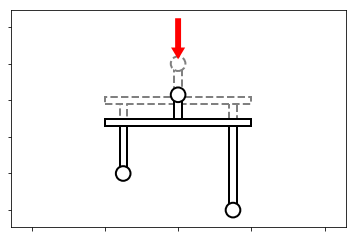

In [130]:
nagy = 100
R = 200

plt.figure()
ax = plt.gca()
ax.set_xticklabels([])
ax.set_yticklabels([])
## eredeti konfiguráció
# rudak
ax.add_patch(mpatches.Rectangle((-R/2,-L1),R,L1,
                                fc = (1,1,1,1),ec = (0.5,0.5,0.5,1), ls = "--", lw = 2))
ax.add_patch(mpatches.Rectangle((-1.5*L1-R/2,-L1-L2),R,L2,
                                fc = (1,1,1,1),ec = (0.5,0.5,0.5,1), ls = "--", lw = 2))
ax.add_patch(mpatches.Rectangle((1.5*L1-R/2,-L1-L3),R,L3,
                                fc = (1,1,1,1),ec = (0.5,0.5,0.5,1), ls = "--", lw = 2))
# csomópontok
ax.add_patch(mpatches.Circle((0,0),R,
                             fc = (1,1,1,1),ec = (0.5,0.5,0.5,1),ls = "--", lw = 2))
ax.add_patch(mpatches.Rectangle((-2*L1,-L1 - R/2),4*L1,R,
                                fc = (1,1,1,1),ec = (0.5,0.5,0.5,1),ls = "--", lw = 2))
# terhelés
ax.add_patch(mpatches.Arrow(0,R+5*R,0,-5*R,
                            fc = (1,0,0,1),ec = (1,0,0,1), lw = 3, width = 2*R))

## elmozdult állapot
# rudak
ax.add_patch(mpatches.Rectangle((-R/2,-L1 + nagy*UG[1]),R,L1 + nagy*(UG[0] - UG[1]),
                                fc = (1,1,1,1),ec = (0,0,0,1), lw = 2))
ax.add_patch(mpatches.Rectangle((-1.5*L1-R/2,-L1-L2 + nagy*UG[2]),R,L2 + nagy*(UG[1] - UG[2]),
                                fc = (1,1,1,1),ec = (0,0,0,1), lw = 2))
ax.add_patch(mpatches.Rectangle((1.5*L1-R/2,-L1-L3  + nagy*UG[3]),R,L3 + nagy*(UG[1] - UG[3]),
                                fc = (1,1,1,1),ec = (0,0,0,1), lw = 2))
# csomópontok
ax.add_patch(mpatches.Circle((0,0+nagy*UG[0]),R,
                             fc = (1,1,1,1),ec = (0,0,0,1), lw = 2))
ax.add_patch(mpatches.Rectangle((-2*L1,-L1 + nagy*UG[1] - R/2),4*L1,R,
                                fc = (1,1,1,1),ec = (0,0,0,1), lw = 2))
ax.add_patch(mpatches.Circle((-1.5*L1,-L1-L2 + nagy*UG[2]),R,
                             fc = (1,1,1,1),ec = (0,0,0,1), lw = 2))
ax.add_patch(mpatches.Circle((1.5*L1,-L1-L3  + nagy*UG[3]),R,
                             fc = (1,1,1,1),ec = (0,0,0,1), lw = 2))

plt.axis("equal")
plt.show()

A teljes csomóponti terhelésvektor 
$\mathbf{F}_\mathrm{TOT} = \mathbf{F}_\mathrm{REAK} + \mathbf{F}_\mathrm{KÜL}$:

In [141]:
FTOT = np.dot(KG,UG)
FTOT

array([-15000.,      0.,  12000.,   3000.])

In [142]:
FREAK = FTOT - FG
FREAK

array([    0.,     0., 12000.,  3000.])

Az egyes elemekhez tartozó lokális elmozdulásvektorok:

In [145]:
Ue1 = UG[en[0]]
Ue1

array([-8.5, -6. ])

In [146]:
Ue2 = UG[en[1]]
Ue2

array([-6.,  0.])

In [147]:
Ue3 = UG[en[2]]
Ue3

array([-6.,  0.])

Az egyes elemekhez tartozó lokális tehervektor:

In [149]:
Fe1 = np.dot(Ke1,Ue1)
Fe1

array([-15000.,  15000.])

In [150]:
Fe2 = np.dot(Ke2,Ue2)
Fe2

array([-12000.,  12000.])

In [151]:
Fe3 = np.dot(Ke3,Ue3)
Fe3

array([-3000.,  3000.])

Tehát a normál igénybevételek:

In [156]:
N1 = Fe1[0]
N1

In [157]:
N2 = Fe2[0]
N2

In [158]:
N3 = Fe3[0]
N3

Vagyis mindegyik rúd nyomó igénybevétel alatt van.

A rudakban ébredő feszültség:

In [159]:
sig1 = N1/A1
sig1

In [160]:
sig2 = N2/A2
sig2

In [161]:
sig3 = N3/A3
sig3

A rudak alapváltozásai:

In [162]:
eps1 = sig1/E1
eps1

In [163]:
eps2 = sig2/E2
eps2

In [164]:
eps3 = sig3/E3
eps3